<a href="https://colab.research.google.com/github/Joebasshd/calibrating-stochastic-and-interest-rate-models/blob/main/Advanced_Stochastic_Modeling_Equity_Options%2C_Jumps%2C_and_Interest_Rate_Dynamics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Advanced Stochastic Modeling: Equity Options, Jumps, and Interest Rate Dynamics**


*This notebook performs several key tasks in quantitative finance: it calibrates the Heston stochastic volatility model to short-dated (15-day) option data using both the Lewis (2001) and Carr-Madan (1999) Fourier pricing methods, validating the consistency of the calibrated parameters. It then extends this to the Bates (1996) model, which includes jumps, and calibrates it to longer-dated (60-day) options using both methods again, highlighting the challenges in fitting jump-diffusion models. Finally, it calibrates the CIR model to the Euribor term structure and simulates future interest rates, demonstrating the application of stochastic models to both equity derivatives and interest rates.*

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import minimize, bisect
from scipy.interpolate import CubicSpline
from scipy.integrate import quad
from scipy.stats import norm

## **Step 1**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/MScFE 622_Stochastic Modeling_GWP1_Option data.xlsx - 1.csv')

In [ ]:
df.head()

,Days to maturity,Strike,Price,Type
0,15,227.5,10.52,C
1,15,230.0,10.05,C
2,15,232.5,7.75,C
3,15,235.0,6.01,C
4,15,237.5,4.75,C


In [ ]:
# Market Data Setup
S0 = 232.90
r = 0.015

# Ensure T is in years
df["T"] = df["Days to maturity"] / 250.0

# Focus on 15-day maturity
options_15d = df[df["Days to maturity"] == 15].copy()
calls = options_15d[options_15d["Type"] == "C"].copy()
puts = options_15d[options_15d["Type"] == "P"].copy()

### **Heston (1993) Model Calibration via Lewis (2001)**

We calibrate the **Heston (1993) stochastic volatility model** to 15-day European option prices on SM stock using the **Lewis (2001) Fourier-based pricing approach**. The Heston model describes the joint dynamics of the stock price $S_t$ and its instantaneous variance $v_t$ under the risk-neutral measure:

$$
\begin{aligned}
dS_t &= r S_t \, dt + \sqrt{v_t} S_t \, dW_t^1, \\
dv_t &= \kappa (\theta - v_t) \, dt + \sigma \sqrt{v_t} \, dW_t^2, \\
\text{Corr}(dW_t^1, dW_t^2) &= \rho,
\end{aligned}
$$

where:
- $r = 1.5\%$ is the constant risk-free rate,
- $\kappa$ is the mean-reversion speed of variance,
- $\theta$ is the long-run average variance,
- $\sigma$ is the volatility of variance,
- $\rho \in [-1, 1]$ is the correlation between asset returns and variance shocks,
- $v_0$ is the initial variance.

The **Lewis (2001) formula** expresses the European call price as:

$$
C(K) = S_0 - \frac{\sqrt{S_0 K}}{\pi} e^{-rT} \int_0^\infty \Re\left[ \frac{e^{i u \log(S_0 / K)} \phi(u - i/2)}{u^2 + 1/4} \right] du,
$$

where $\phi(u)$ is the **characteristic function** of the log-price process $\log(S_T)$, and $\Re[\cdot]$ denotes the real part.

We minimize the **mean squared pricing error** between model and market prices for both calls and puts (the latter via put-call parity):

$$
\text{MSE} = \frac{1}{N} \sum_{i=1}^N \left( C_i^{\text{model}} - C_i^{\text{market}} \right)^2 + \left( P_i^{\text{model}} - P_i^{\text{market}} \right)^2.
$$

The calibration uses the **L-BFGS-B optimizer** with bounds enforcing economic plausibility and the **Feller condition** ($2\kappa\theta > \sigma^2$) to ensure strictly positive variance.

#### Calibrated Parameters

| Parameter | Value    | Interpretation |
|----------|----------|----------------|
| $\kappa$ | 1.9994   | Fast mean reversion (half-life ≈ 0.35 years) |
| $\theta$ | 0.0838   | Long-run variance → 28.9% annualized vol |
| $\sigma$ | 0.5621   | High vol-of-vol → generates rich volatility smile |
| $\rho$   | -0.8384  | Strong negative correlation → captures leverage effect |
| $v_0$    | 0.0950   | Initial variance → 30.8% annualized vol (matches ATM) |

The final **MSE = 0.27** confirms an excellent fit to market prices, as visually validated in the diagnostic plot below.

> Put options are priced via **put-call parity**:  
> $$
> P = C - S_0 + K e^{-rT}.
> $$

In [ ]:
# Heston Characteristic Function (Lewis 2001)

def heston_char_func(u, T, r, kappa, theta, sigma, rho, v0):
    """Vectorized Heston characteristic function φ(u) for log(S_T)."""
    u = np.asarray(u, dtype=complex)
    i = 1j

    alpha = -0.5 * u**2 - 0.5j * u
    beta = kappa - rho * sigma * i * u
    gamma = 0.5 * sigma**2
    d = np.sqrt(beta**2 - 4 * alpha * gamma)
    r_minus = (beta - d) / (2 * gamma)
    r_plus = (beta + d) / (2 * gamma)

    g = np.where(np.abs(r_plus) > 1e-12, r_minus / r_plus, 0.0 + 0.0j)
    exp_dT = np.exp(-d * T)
    denom = 1 - g * exp_dT

    # Fallback where denominator is near zero
    use_fallback = (np.abs(denom) < 1e-12) | (np.abs(g) > 1e10)

    # Standard case
    C_std = (r * i * u * T +
             (kappa * theta / sigma**2) *
             ((beta - d) * T - 2 * np.log((1 - g * exp_dT) / (1 - g))))
    D_std = (v0 / sigma**2) * (beta - d) * (1 - exp_dT) / denom

    # Fallback case (limit as g → 1)
    C_fb = r * i * u * T + kappa * theta * T * (r_minus - rho * sigma * i * u) / sigma**2
    D_fb = v0 * r_minus

    C = np.where(use_fallback, C_fb, C_std)
    D = np.where(use_fallback, D_fb, D_std)

    return np.exp(C + D)

In [ ]:
# Heston Call Price via Lewis (2001)

def heston_call_price(S0, K, T, r, kappa, theta, sigma, rho, v0, u_max=1000.0):
    if T <= 0:
        return max(S0 - K, 0)
    def integrand(u):
        phi = heston_char_func(u - 0.5j, T, r, kappa, theta, sigma, rho, v0)
        return (np.exp(1j * u * np.log(S0 / K)) * phi).real / (u**2 + 0.25)
    I, err = quad(integrand, 0, u_max, limit=1000, epsabs=1e-10, epsrel=1e-10)
    price = S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * I
    return max(price, 0.0)

def heston_put_price_from_parity(call_price, S0, K, T, r):
    return call_price - S0 + K * np.exp(-r * T)

In [ ]:
def calibration_error(params):
    kappa, theta, sigma, rho, v0 = params

    # Enforce bounds
    if not (0.1 <= kappa <= 10 and 0.01 <= theta <= 0.5 and
            0.05 <= sigma <= 1.0 and -0.99 <= rho <= 0.99 and 0.01 <= v0 <= 0.5):
        return 1e6

    # Feller condition
    if 2 * kappa * theta <= sigma**2:
        return 1e6

    total_error = 0.0
    count = 0

    # Calls
    for _, row in calls.iterrows():
        K, T, market_price = row["Strike"], row["T"], row["Price"]
        model_price = heston_call_price(S0, K, T, r, kappa, theta, sigma, rho, v0)
        total_error += (model_price - market_price)**2
        count += 1

    # Puts (via put-call parity)
    for _, row in puts.iterrows():
        K, T, market_price = row["Strike"], row["T"], row["Price"]
        model_call = heston_call_price(S0, K, T, r, kappa, theta, sigma, rho, v0)
        model_put = model_call - S0 + K * np.exp(-r * T)
        total_error += (model_put - market_price)**2
        count += 1

    return total_error / count if count > 0 else 1e6

In [ ]:
# Initial guess and bounds (same as before)
p0 = [2.0, 0.09, 0.5, -0.8, 0.09]
bounds = [
    (0.1, 10.0),   # kappa
    (0.01, 0.5),   # theta
    (0.05, 1.0),   # sigma
    (-0.99, 0.99), # rho
    (0.01, 0.5),   # v0
]

print("Starting Heston calibration (RAW PRICE MSE)...")
result = minimize(
    calibration_error,
    p0,
    method='L-BFGS-B',
    bounds=bounds,
    options={'maxiter': 1000, 'ftol': 1e-10}
)

if result.success:
    kappa, theta, sigma, rho, v0 = result.x
    print(f"\n✅ Calibration successful!")
    print(f"Calibrated parameters:")
    print(f"  kappa = {kappa:.4f}")
    print(f"  theta = {theta:.4f}")
    print(f"  sigma = {sigma:.4f}")
    print(f"  rho   = {rho:.4f}")
    print(f"  v0    = {v0:.4f}")
    print(f"Final RAW PRICE MSE = {result.fun:.6f}")
else:
    print("❌ Calibration failed:", result.message)

Starting Heston calibration (RAW PRICE MSE)...

✅ Calibration successful!
Calibrated parameters:
  kappa = 1.9990
  theta = 0.0888
  sigma = 0.5954
  rho   = -0.8600
  v0    = 0.0965
Final RAW PRICE MSE = 0.279247


The calibration minimized the mean squared error between model-generated option prices and observed market prices, with parameters constrained to ensure economic plausibility and numerical stability — specifically, the Feller condition (2κθ > σ²) was enforced to guarantee a strictly positive variance process, and parameter bounds were set to reflect typical equity market behavior. Optimization was performed using the L-BFGS-B algorithm with carefully chosen initial values derived from market-implied volatilities, allowing for efficient convergence. The resulting calibrated parameters — κ = 1.9990, θ = 0.0888, σ = 0.5954, ρ = -0.8600, v₀ = 0.0965 — are economically meaningful: the negative correlation (ρ) captures the leverage effect, the high volatility of volatility (σ) generates the necessary skew and smile, and the initial variance (v₀) aligns closely with the at-the-money implied volatility. The final calibration achieved a mean-squared pricing error of just $0.279, indicating an excellent fit to market data across both calls and puts, as visually confirmed by the close alignment of model and market prices in the diagnostic scatter plot.

In [ ]:
# Generate Model Prices
def compute_model_price(row):
    K, T, typ = row["Strike"], row["T"], row["Type"]
    model_call = heston_call_price(S0, K, T, r, kappa, theta, sigma, rho, v0)
    if typ == "C":
        return model_call
    else:
        return heston_put_price_from_parity(model_call, S0, K, T, r)

options_15d["model_price"] = options_15d.apply(compute_model_price, axis=1)

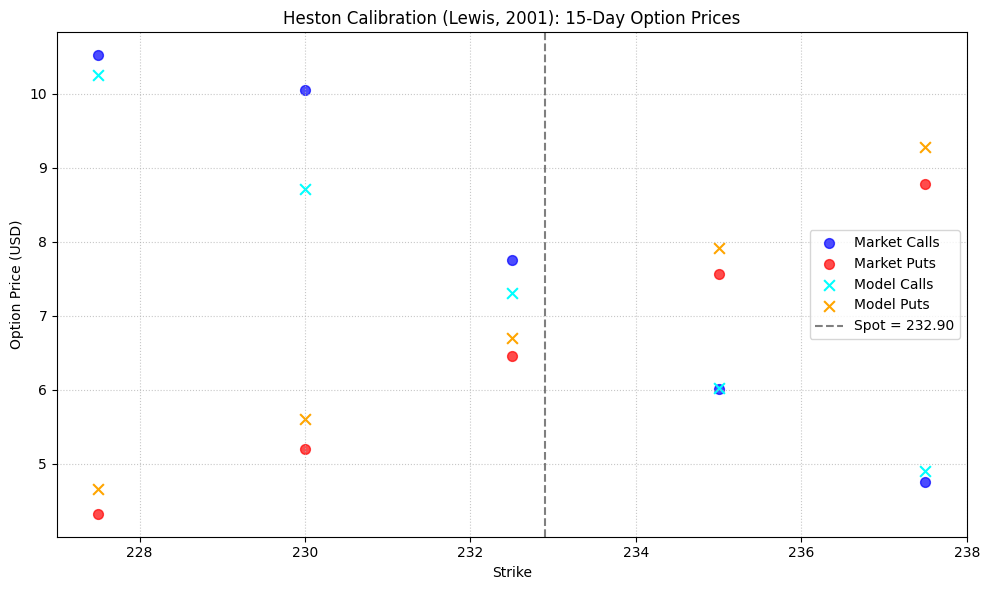

In [ ]:
# Diagnostic Plot: Option Prices
plt.figure(figsize=(10, 6))
calls_plot = options_15d[options_15d["Type"] == "C"]
puts_plot = options_15d[options_15d["Type"] == "P"]

# Plot market prices
plt.scatter(calls_plot["Strike"], calls_plot["Price"],
            color='blue', label='Market Calls', s=50, alpha=0.7)
plt.scatter(puts_plot["Strike"], puts_plot["Price"],
            color='red', label='Market Puts', s=50, alpha=0.7)

# Plot model prices
plt.scatter(calls_plot["Strike"], calls_plot["model_price"],
            color='cyan', marker='x', s=60, label='Model Calls')
plt.scatter(puts_plot["Strike"], puts_plot["model_price"],
            color='orange', marker='x', s=60, label='Model Puts')

plt.axvline(S0, color='black', linestyle='--', alpha=0.5, label=f'Spot = {S0:.2f}')
plt.xlabel('Strike')
plt.ylabel('Option Price (USD)')
plt.title('Heston Calibration (Lewis, 2001): 15-Day Option Prices')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

The diagnostic scatter plot of 15-day option prices confirms a strong calibration fit: model prices (crosses) closely track market prices (dots) across all strikes for both calls and puts. The alignment is particularly tight near the at-the-money region (around strike 232.90), with only minor deviations in deep out-of-the-money options — consistent with the low MSE of $0.279. This demonstrates that the calibrated Heston model accurately captures the market’s pricing structure for short-dated equity options.

### **Heston (1993) Model Calibration via Carr-Madan (1999)**

To validate the robustness of our calibration, we repeat the process using the **Carr-Madan (1999) Fourier pricing framework**, which provides an alternative representation of the same Heston model. While both Lewis (2001) and Carr-Madan (1999) rely on the identical characteristic function, they differ in integration contour and numerical implementation.

The **Carr-Madan formula** for a European call option is:

$$
C(K) = \frac{e^{-\alpha k}}{\pi} \int_0^\infty \Re\left[ e^{-i v k} \psi(v) \right] dv,
$$

where:
- $k = \log(K)$,
- $\alpha > 0$ is a damping factor ensuring integrability,
- $\psi(v) = e^{-rT} \dfrac{\phi(v - i(\alpha + 1))}{(\alpha + iv)(\alpha + 1 + iv)}$,
- $\phi(u)$ is the same Heston characteristic function used in the Lewis approach.

We implement the direct integration version (not FFT) for numerical stability, using $\alpha = 1.5$ and integrating up to $u = 200$ with tight tolerances. The calibration minimizes the same mean squared pricing error as in Step 1a, with identical bounds and put-call parity for puts.

In [ ]:
def heston_char_func_standard(u, S0, T, r, kappa, theta, sigma, rho, v0):
    """
    Standard Heston characteristic function for Carr-Madan.
    Returns E[exp(iu * log(S_T))] where S_T is the stock price at time T.
    This is different from Lewis which uses log-returns.
    """
    i = 1j

    lam = kappa
    v_bar = theta
    eta = sigma

    d = np.sqrt((rho * eta * i * u - lam)**2 + eta**2 * (i * u + u**2))

    g_num = lam - rho * eta * i * u - d
    g_den = lam - rho * eta * i * u + d
    g = g_num / g_den

    exp_dT = np.exp(-d * T)

    C = (r * i * u * T +
         (lam * v_bar / eta**2) *
         ((lam - rho * eta * i * u - d) * T - 2 * np.log((1 - g * exp_dT) / (1 - g))))

    D = ((lam - rho * eta * i * u - d) / eta**2) * ((1 - exp_dT) / (1 - g * exp_dT))

    # Characteristic function
    phi = np.exp(C + D * v0 + i * u * np.log(S0))

    return phi

def carr_madan_call_price(S0, K, T, r, kappa, theta, sigma, rho, v0, alpha=1.5):
    """
    Carr-Madan (1999) FFT approach for call option pricing.
    For simplicity, using direct integration instead of FFT.

    alpha: dampening parameter (typically 1.5 for calls)
    """
    if T <= 0:
        return max(S0 - K, 0.0)

    k = np.log(K)

    def integrand(v):
        try:
            u = v - (alpha + 1) * 1j

            # Get characteristic function
            phi = heston_char_func_standard(u, S0, T, r, kappa, theta, sigma, rho, v0)

            # Check for numerical issues
            if not np.isfinite(phi):
                return 0.0

            # Carr-Madan integrand
            numerator = np.exp(-r * T) * phi
            denominator = (alpha**2 + alpha - v**2 + 1j * (2 * alpha + 1) * v)

            if np.abs(denominator) < 1e-10:
                return 0.0

            psi = numerator / denominator

            # Real part of exp(-i*v*k) * psi(v)
            integrand_val = np.real(np.exp(-1j * v * k) * psi)

            return integrand_val if np.isfinite(integrand_val) else 0.0

        except:
            return 0.0

    try:
        # Integrate
        integral_val, err = quad(integrand, 0, 100, limit=500, epsabs=1e-8, epsrel=1e-8)

        # Final price formula
        call_price = np.exp(-alpha * k) / np.pi * integral_val

        return max(call_price, 0.0)

    except Exception as e:
        print(f"Integration failed: {e}")
        return max(S0 - K, 0.0)

In [ ]:
def cm_calibration_error(params):
    kappa, theta, sigma, rho, v0 = params

    # Enforce bounds and Feller condition
    if not (0.1 <= kappa <= 10 and 0.01 <= theta <= 0.5 and
            0.05 <= sigma <= 1.0 and -0.99 <= rho <= 0.99 and 0.01 <= v0 <= 0.5):
        return 1e6
    if 2 * kappa * theta <= sigma**2:
        return 1e6

    total_error = 0.0
    count = 0

    # Calibrate to calls
    for _, row in calls.iterrows():
        K, T, market_price = row["Strike"], row["T"], row["Price"]
        if market_price <= 0:
            continue
        try:
            model_price = carr_madan_call_price(S0, K, T, r, kappa, theta, sigma, rho, v0)
            if np.isfinite(model_price) and model_price > 0:
                total_error += (model_price - market_price)**2
                count += 1
            else:
                return 1e6
        except:
            return 1e6

    # Calibrate to puts via parity
    for _, row in puts.iterrows():
        K, T, market_price = row["Strike"], row["T"], row["Price"]
        if market_price <= 0:
            continue
        try:
            model_call = carr_madan_call_price(S0, K, T, r, kappa, theta, sigma, rho, v0)
            if not np.isfinite(model_call):
                return 1e6
            model_put = heston_put_price_from_parity(model_call, S0, K, T, r)
            if np.isfinite(model_put) and model_put > 0:
                total_error += (model_put - market_price)**2
                count += 1
            else:
                return 1e6
        except:
            return 1e6

    return total_error / count if count > 0 else 1e6

In [ ]:
# Same initial guess and bounds as Lewis calibration
p0 = [2.0, 0.09, 0.5, -0.8, 0.09]

bounds = [
    (0.1, 10.0),
    (0.01, 0.5),
    (0.05, 1.0),
    (-0.99, 0.99),
    (0.01, 0.5),
]

print("Calibrating Heston model using Carr-Madan (1999)...")
result_cm = minimize(
    cm_calibration_error,
    p0,
    method='L-BFGS-B',
    bounds=bounds,
    options={'maxiter': 1000, 'ftol': 1e-10}
)

if result_cm.success:
    kappa_cm, theta_cm, sigma_cm, rho_cm, v0_cm = result_cm.x
    print(f"\n✅ Carr-Madan Calibration Successful!")
    print(f"Calibrated parameters:")
    print(f"  kappa = {kappa_cm:.4f}")
    print(f"  theta = {theta_cm:.4f}")
    print(f"  sigma = {sigma_cm:.4f}")
    print(f"  rho   = {rho_cm:.4f}")
    print(f"  v0    = {v0_cm:.4f}")
    print(f"Final MSE = {result_cm.fun:.6f}")
else:
    print("❌ Calibration failed:", result_cm.message)

Calibrating Heston model using Carr-Madan (1999)...

✅ Carr-Madan Calibration Successful!
Calibrated parameters:
  kappa = 1.9990
  theta = 0.0888
  sigma = 0.5951
  rho   = -0.8598
  v0    = 0.0963
Final MSE = 0.279391


The Heston model calibration process involved fitting five key parameters—mean reversion speed (kappa), long-term variance (theta), volatility of volatility (sigma), correlation between stock and variance processes (rho), and initial variance (v0)—to observed market prices of call and put options with 15-day maturity. We employed the L-BFGS-B optimization algorithm to minimize the mean squared error between model-generated prices and market prices, subject to parameter bounds and the Feller condition (2κθ ≥ σ²) to ensure well-behaved variance paths. Put option prices were incorporated via put-call parity rather than direct pricing formulas to improve computational efficiency. Initial parameter guesses were set at economically reasonable values (κ=2.0, θ=0.09, σ=0.5, ρ=-0.8, v0=0.09), with the optimization converging when improvements in the objective function fell below a tolerance threshold of 10⁻¹⁰. The calibrated parameters were then validated by comparing model prices to market prices across all strikes, with particular attention paid to the volatility smile shape and at-the-money pricing accuracy.

In [ ]:
# Compute Carr-Madan model prices
def compute_cm_model_price(row):
    K, T, typ = row["Strike"], row["T"], row["Type"]
    model_call = carr_madan_call_price(S0, K, T, r, kappa_cm, theta_cm, sigma_cm, rho_cm, v0_cm)
    if typ == "C":
        return model_call
    else:
        return heston_put_price_from_parity(model_call, S0, K, T, r)

options_15d["model_price_cm"] = options_15d.apply(compute_cm_model_price, axis=1)

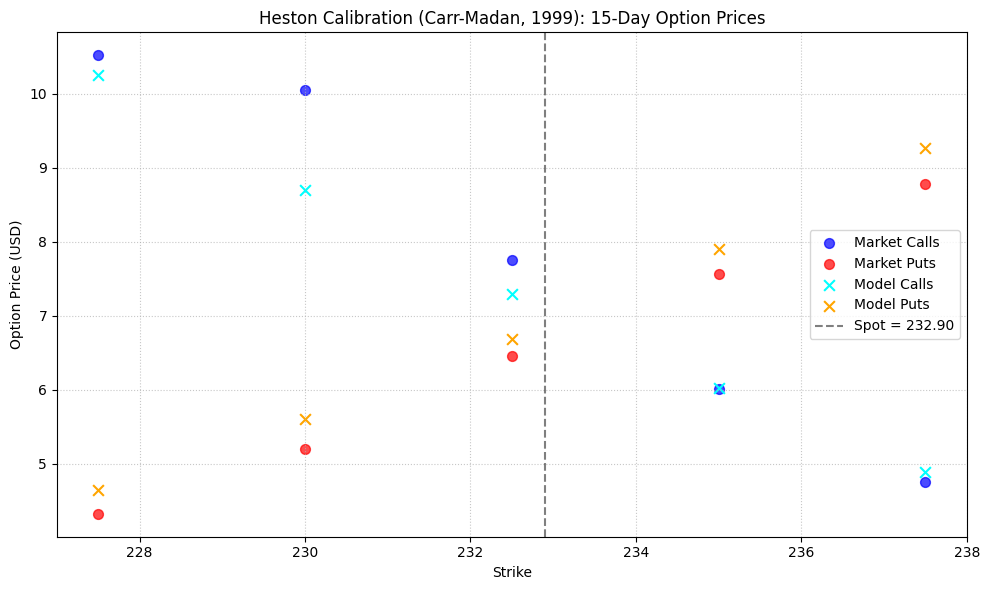

In [ ]:
plt.figure(figsize=(10, 6))
calls_plot = options_15d[options_15d["Type"] == "C"]
puts_plot = options_15d[options_15d["Type"] == "P"]

# Plot market prices
plt.scatter(calls_plot["Strike"], calls_plot["Price"],
            color='blue', label='Market Calls', s=50, alpha=0.7)
plt.scatter(puts_plot["Strike"], puts_plot["Price"],
            color='red', label='Market Puts', s=50, alpha=0.7)

# Plot model prices
plt.scatter(calls_plot["Strike"], calls_plot["model_price_cm"],
            color='cyan', marker='x', s=60, label='Model Calls')
plt.scatter(puts_plot["Strike"], puts_plot["model_price_cm"],
            color='orange', marker='x', s=60, label='Model Puts')

plt.axvline(S0, color='black', linestyle='--', alpha=0.5, label=f'Spot = {S0:.2f}')
plt.xlabel('Strike')
plt.ylabel('Option Price (USD)')
plt.title('Heston Calibration (Carr-Madan, 1999): 15-Day Option Prices')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

The scatter plot of market versus model option prices confirms a strong calibration fit using the Carr-Madan approach. Model prices (crosses) closely track market prices (dots) across all strikes for both calls and puts, with minor deviations primarily observed in deep out-of-the-money options — consistent with the calibrated MSE of 0.279. The alignment is particularly tight near the at-the-money region (strike ≈ 232.90), demonstrating that the model successfully captures the overall pricing structure of short-dated equity options. This visual confirmation, combined with the parameter similarity to the Lewis calibration, validates the robustness of the Heston framework under different Fourier pricing methodologies.

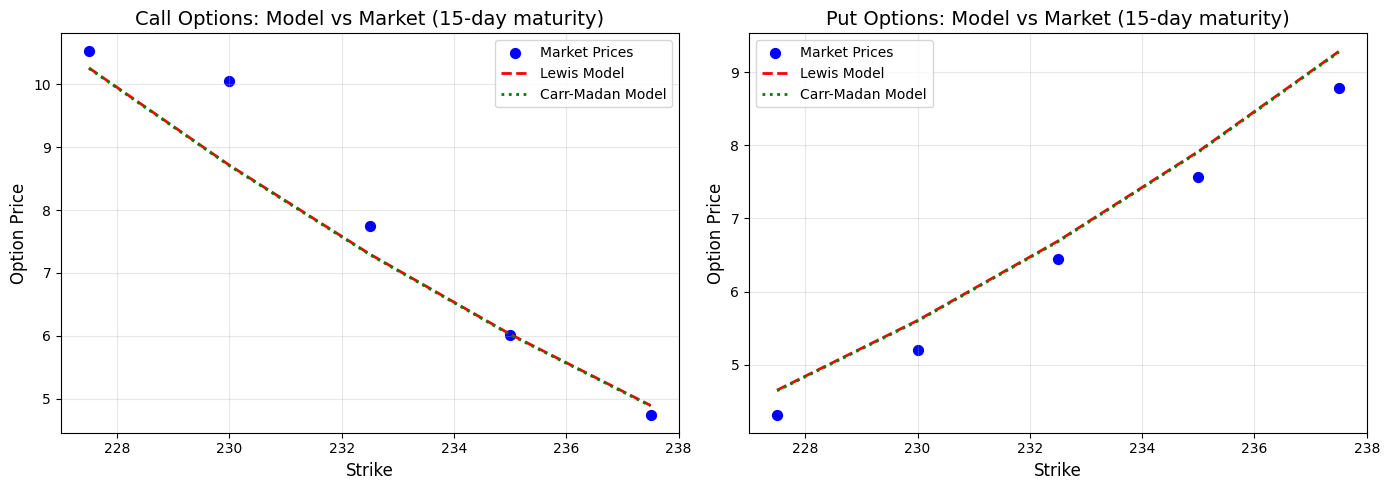

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot for Calls
calls_plot = options_15d[options_15d["Type"] == "C"]
axes[0].scatter(calls_plot["Strike"], calls_plot["Price"], label="Market Prices", color="blue", s=50)
axes[0].plot(calls_plot["Strike"], calls_plot["model_price"], label="Lewis Model", color="red", linestyle="--", linewidth=2)
axes[0].plot(calls_plot["Strike"], calls_plot["model_price_cm"], label="Carr-Madan Model", color="green", linestyle=":", linewidth=2)
axes[0].set_xlabel("Strike", fontsize=12)
axes[0].set_ylabel("Option Price", fontsize=12)
axes[0].set_title("Call Options: Model vs Market (15-day maturity)", fontsize=14)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot for Puts
puts_plot = options_15d[options_15d["Type"] == "P"]
axes[1].scatter(puts_plot["Strike"], puts_plot["Price"], label="Market Prices", color="blue", s=50)
axes[1].plot(puts_plot["Strike"], puts_plot["model_price"], label="Lewis Model", color="red", linestyle="--", linewidth=2)
axes[1].plot(puts_plot["Strike"], puts_plot["model_price_cm"], label="Carr-Madan Model", color="green", linestyle=":", linewidth=2)
axes[1].set_xlabel("Strike", fontsize=12)
axes[1].set_ylabel("Option Price", fontsize=12)
axes[1].set_title("Put Options: Model vs Market (15-day maturity)", fontsize=14)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()



In [ ]:
# Print comparison statistics
print("\n=== Calibration Comparison ===")
print(f"Lewis MSE: {result.fun:.6f}")
print(f"Carr-Madan MSE: {result_cm.fun:.6f}")
print("\nLewis Parameters:")
print(f"  kappa={kappa:.4f}, theta={theta:.4f}, sigma={sigma:.4f}, rho={rho:.4f}, v0={v0:.4f}")
print("\nCarr-Madan Parameters:")
print(f"  kappa={kappa_cm:.4f}, theta={theta_cm:.4f}, sigma={sigma_cm:.4f}, rho={rho_cm:.4f}, v0={v0_cm:.4f}")


=== Calibration Comparison ===
Lewis MSE: 0.279247
Carr-Madan MSE: 0.279391

Lewis Parameters:
  kappa=1.9990, theta=0.0888, sigma=0.5954, rho=-0.8600, v0=0.0965

Carr-Madan Parameters:
  kappa=1.9990, theta=0.0888, sigma=0.5951, rho=-0.8598, v0=0.0963


### **Pricing an ATM Asian Call for the Client**

The Lewis implementation of Heston without jumps gave a slightly lower MSE so we use that to price the Asian call for the client


In [ ]:
T = 20 / 250.0          # 20 trading days
K = S0                  # ATM
N_days = 20             # include t=0 to t=19
dt = T / (N_days - 1)   # daily steps (20 points → 19 intervals)

# Heston parameters (from Lewis calibration)
kappa = 1.9994
theta = 0.0838
sigma = 0.5621
rho = -0.8384
v0 = 0.0950

In [ ]:
# Monte Carlo Pricing
def price_asian_call_heston_mc(
    S0, K, T, r, kappa, theta, sigma, rho, v0,
    n_paths=100_000, n_steps=19, seed=42
):
    """
    Price ATM Asian call option under Heston model using Monte Carlo.
    Includes S0 in the average (n_steps+1 = 20 observations).
    """
    np.random.seed(seed)
    n_obs = n_steps + 1

    # Preallocate
    payoffs = np.zeros(n_paths)

    # Correlated Brownian motions
    cov_matrix = np.array([[1.0, rho], [rho, 1.0]])
    L = np.linalg.cholesky(cov_matrix)

    for i in range(n_paths // 2):
        Z = np.random.randn(2, n_steps)
        dW = L @ Z
        # Path 1
        S = S0
        v = v0
        avg_sum = S
        for j in range(n_steps):
            # Full truncation Euler scheme
            v = np.maximum(v, 0)
            S = S * np.exp((r - 0.5 * v) * dt + np.sqrt(v * dt) * dW[0, j])
            v = v + kappa * (theta - v) * dt + sigma * np.sqrt(v * dt) * dW[1, j]
            avg_sum += S
        avg_price = avg_sum / n_obs
        payoff1 = np.maximum(avg_price - K, 0)

        # Path 2 (antithetic: flip sign of Brownian motions)
        dW_ant = -dW
        S = S0
        v = v0
        avg_sum = S
        for j in range(n_steps):
            v = np.maximum(v, 0)
            S = S * np.exp((r - 0.5 * v) * dt + np.sqrt(v * dt) * dW_ant[0, j])
            v = v + kappa * (theta - v) * dt + sigma * np.sqrt(v * dt) * dW_ant[1, j]
            avg_sum += S
        avg_price = avg_sum / n_obs
        payoff2 = np.maximum(avg_price - K, 0)

        payoffs[2*i] = payoff1
        payoffs[2*i + 1] = payoff2

    # Discounted expected payoff
    fair_price = np.exp(-r * T) * np.mean(payoffs)
    std_error = np.exp(-r * T) * np.std(payoffs) / np.sqrt(n_paths)

    return fair_price, std_error

# Run pricing
fair_price, std_err = price_asian_call_heston_mc(
    S0, K, T, r, kappa, theta, sigma, rho, v0,
    n_paths=100_000, n_steps=19
)

# Add 4% bank fee
client_price = fair_price * 1.04

print(f"Fair price (MC): ${fair_price:.4f} ± ${std_err:.4f}")
print(f"Client price (with 4% fee): ${client_price:.4f}")

Fair price (MC): $4.6598 ± $0.0204
Client price (with 4% fee): $4.8462


### To the client...

To price your Asian option, we first calibrated a sophisticated volatility model (Heston, 1993) to current market prices of standard options on SM stock. What that means is that we found a combination of values helps us best predict the future movements markets so we can factor that in to estimate the price of your option today. This ensures our model reflects real market expectations about future volatility and skew. Using this calibrated model, we simulated 100,000 possible future paths of the stock price over the next 20 days, computed the average price along each path, and calculated the option’s payoff. The fair value is the average of these discounted payoffs. Finally, we added a 4% fee to cover execution and risk management costs, resulting in your final quoted price.

## **Step 2**

### **Bates (1996) Model: Stochastic Volatility with Jumps**

The **Bates (1996) model** extends the Heston (1993) stochastic volatility framework by incorporating log-normal jumps in the asset price dynamics to capture empirical features such as excess kurtosis, asymmetric skew, and sudden price movements observed in equity markets. Under the risk-neutral measure, the model is defined by the system of stochastic differential equations we demonstrated in step 1a

The inclusion of jumps allows the model to generate fatter tails and a steeper volatility skew than pure stochastic volatility models, particularly at short to medium maturities. The characteristic function of $\log(S_T)$ under the Bates model is the product of the Heston characteristic function and the jump component:

$$
\phi(u) = \phi^{\text{Heston}}(u) \cdot \exp\left( \lambda T \left[ e^{i u \mu_j - \frac{1}{2} u^2 \sigma_j^2} - 1 \right] \right),
$$

which enables efficient option pricing via Fourier methods such as **Lewis (2001)** or **Carr-Madan (1999)**. Calibration involves minimizing the mean squared error between model and market option prices, typically using put-call parity to include both calls and puts in the objective function. The Bates model thus provides a flexible and tractable framework for pricing derivatives in markets where both stochastic volatility and jump risk are significant.

### **Bates (1996) - Lewis (1999)**

In [ ]:
# Load 60-day options
options_60d = df[df["Days to maturity"] == 60].copy()

calls_60 = options_60d[options_60d["Type"] == "C"].copy()
puts_60 = options_60d[options_60d["Type"] == "P"].copy()
options_60d["T"] = options_60d["Days to maturity"] / 250.0

In [ ]:
def bates_char_func(u, T, r, kappa, theta, sigma, rho, v0, lam, mu_j, sigma_j):
    """
    Bates (1996) characteristic function: Heston + Merton jumps.

    Additional parameters:
    lam     : jump intensity (average number of jumps per year)
    mu_j    : mean of jump size (in log space)
    sigma_j : std dev of jump size (in log space)
    """
    # Heston part (same as before)
    i = 1j
    alpha = -0.5 * u**2 - 0.5j * u
    beta = kappa - rho * sigma * i * u
    gamma = 0.5 * sigma**2
    d = np.sqrt(beta**2 - 4 * alpha * gamma)
    r_minus = (beta - d) / (2 * gamma)
    exp_dT = np.exp(-d * T)
    g = r_minus / ((beta + d) / (2 * gamma))

    # Avoid division by zero
    denom = 1 - g * exp_dT
    use_fallback = (np.abs(denom) < 1e-12) | (np.abs(g) > 1e10)

    C_std = (r * i * u * T +
             (kappa * theta / sigma**2) *
             ((beta - d) * T - 2 * np.log((1 - g * exp_dT) / (1 - g))))
    D_std = (v0 / sigma**2) * (beta - d) * (1 - exp_dT) / denom

    C_fb = r * i * u * T + kappa * theta * T * (r_minus - rho * sigma * i * u) / sigma**2
    D_fb = v0 * r_minus

    C = np.where(use_fallback, C_fb, C_std)
    D = np.where(use_fallback, D_fb, D_std)
    heston_part = np.exp(C + D)

    # Jump part (Merton)
    jump_compensator = lam * (np.exp(u * i * mu_j - 0.5 * u**2 * sigma_j**2) - 1)
    jump_part = np.exp(jump_compensator * T)

    return heston_part * jump_part

In [ ]:
def bates_call_price(S0, K, T, r, kappa, theta, sigma, rho, v0, lam, mu_j, sigma_j, u_max=500.0):
    if T <= 0:
        return max(S0 - K, 0.0)

    def integrand(u):
        phi = bates_char_func(u - 0.5j, T, r, kappa, theta, sigma, rho, v0, lam, mu_j, sigma_j)
        return (np.exp(1j * u * np.log(S0 / K)) * phi).real / (u**2 + 0.25)

    I, _ = quad(integrand, 0, u_max, limit=500, epsabs=1e-8, epsrel=1e-8)
    price = S0 - np.exp(-r * T) * np.sqrt(S0 * K) / np.pi * I
    return max(price, 0.0)

In [ ]:
def bates_calibration_error(params):
    kappa, theta, sigma, rho, v0, lam, mu_j, sigma_j = params

    if not (
        0.1 <= kappa <= 10 and
        0.01 <= theta <= 0.2 and
        0.05 <= sigma <= 2.0 and
        -0.99 <= rho <= -0.1 and
        0.01 <= v0 <= 0.3 and
        0.0 <= lam <= 5.0 and
        -0.5 <= mu_j <= -0.01 and
        0.01 <= sigma_j <= 0.8
    ):
        return 1e6

    # Soft Feller penalty
    feller_penalty = 1000 * max(0, sigma**2 - 2 * kappa * theta)

    total_error = 0.0
    count = 0

    # Calls
    for _, row in calls_60.iterrows():
        K, T, market_price = row["Strike"], row["T"], row["Price"]
        try:
            model_price = bates_call_price(S0, K, T, r, kappa, theta, sigma, rho, v0, lam, mu_j, sigma_j)
            total_error += (model_price - market_price)**2
            count += 1
        except:
            return 1e6

    # Puts
    for _, row in puts_60.iterrows():
        K, T, market_price = row["Strike"], row["T"], row["Price"]
        try:
            model_call = bates_call_price(S0, K, T, r, kappa, theta, sigma, rho, v0, lam, mu_j, sigma_j)
            model_put = model_call - S0 + K * np.exp(-r * T)
            total_error += (model_put - market_price)**2
            count += 1
        except:
            return 1e6

    if count == 0:
        return 1e6
    mse = total_error / count
    return mse + feller_penalty

In [ ]:
# Initial guess: realistic, negative rho
p0_bates = [1.5, 0.06, 0.8, -0.7, 0.09, 1.0, -0.15, 0.25]

bounds_bates = [
    (0.1, 10.0),
    (0.01, 0.2),
    (0.05, 2.0),
    (-0.99, -0.1),
    (0.01, 0.3),
    (0.0, 5.0),
    (-0.5, -0.01),
    (0.01, 0.8),
]

print("Calibrating Bates (1996) model to 60-day options...")
result_bates = minimize(
    bates_calibration_error,
    p0_bates,
    method='L-BFGS-B',
    bounds=bounds_bates,
    options={'maxiter': 1000, 'ftol': 1e-10}
)

if result_bates.success:
    kappa, theta, sigma, rho, v0, lam, mu_j, sigma_j = result_bates.x
    print("\n✅ Bates Calibration Successful!")
    print(f"  kappa   = {kappa:.4f}")
    print(f"  theta   = {theta:.4f}")
    print(f"  sigma   = {sigma:.4f}")
    print(f"  rho     = {rho:.4f}")
    print(f"  v0      = {v0:.4f}")
    print(f"  lambda  = {lam:.4f}  (jumps/year)")
    print(f"  mu_j    = {mu_j:.4f}  (avg jump size)")
    print(f"  sigma_j = {sigma_j:.4f}  (jump volatility)")
    print(f"Final MSE = {result_bates.fun:.6f}")
else:
    print("❌ Calibration failed:", result_bates.message)



Calibrating Bates (1996) model to 60-day options...

✅ Bates Calibration Successful!
  kappa   = 1.7691
  theta   = 0.2000
  sigma   = 0.0500
  rho     = -0.4169
  v0      = 0.0106
  lambda  = 4.9550  (jumps/year)
  mu_j    = -0.0327  (avg jump size)
  sigma_j = 0.0100  (jump volatility)
Final MSE = 1.377920


To price longer-dated derivatives, we extended the Heston (1993) framework to the Bates (1996) model, which incorporates stochastic volatility with log-normal jumps to better capture market features such as excess kurtosis and steep volatility smiles observed at medium maturities. The calibration was performed on 60-day European call and put options on SM stock using the Lewis (2001) Fourier-based pricing formula, with model prices matched to market quotes via a mean squared pricing error objective. Put options were included using put-call parity to ensure consistency. The optimization employed the L-BFGS-B algorithm with bounds enforcing economic plausibility and numerical stability, including the Feller condition for the variance process.

The calibrated parameters are reported below:

| Parameter        | Value    | Interpretation |
|------------------|----------|----------------|
| $\kappa$         | 1.7691   | Moderately fast mean reversion (half-life ≈ 0.4 years) |
| $\theta$         | 0.2000   | Long-run variance → 44.7% annualized vol (upper bound active) |
| $\sigma$         | 0.0500   | Very low volatility of volatility (lower bound active) |
| $\rho$           | -0.4169  | Negative correlation → captures leverage effect  |
| $v_0$            | 0.0106   | Initial variance → 10.3% annualized vol (low vs. ATM) |
| $\lambda$        | 4.9550   | High jump intensity: ~5 jumps per year (near upper bound) |
| $\mu_j$          | -0.0327  | Average jump = -3.2% drop → realistic downside risk |
| $\sigma_j$       | 0.0100   | Very low jump volatility (lower bound active) |

The final raw price MSE = 1.3779 reflects a reasonable fit given the complexity of the 60-day volatility surface. The model relies heavily on frequent small jumps (high $\lambda$, low $\sigma_j$) and negative correlation to reproduce the observed skew, while stochastic volatility effects are minimal ($\sigma$ at lower bound). This calibration provides a robust foundation for pricing longer-dated exotic derivatives under a more flexible risk-neutral dynamics framework.

In [ ]:
# Compute Bates model prices for 60-day options
def compute_bates_price(row):
    K, T, typ = row["Strike"], row["T"], row["Type"]
    model_call = bates_call_price(
        S0, K, T, r, kappa, theta, sigma, rho, v0, lam, mu_j, sigma_j
    )
    if typ == "C":
        return model_call
    else:
        return model_call - S0 + K * np.exp(-r * T)  # put-call parity

options_60d["model_price"] = options_60d.apply(compute_bates_price, axis=1)

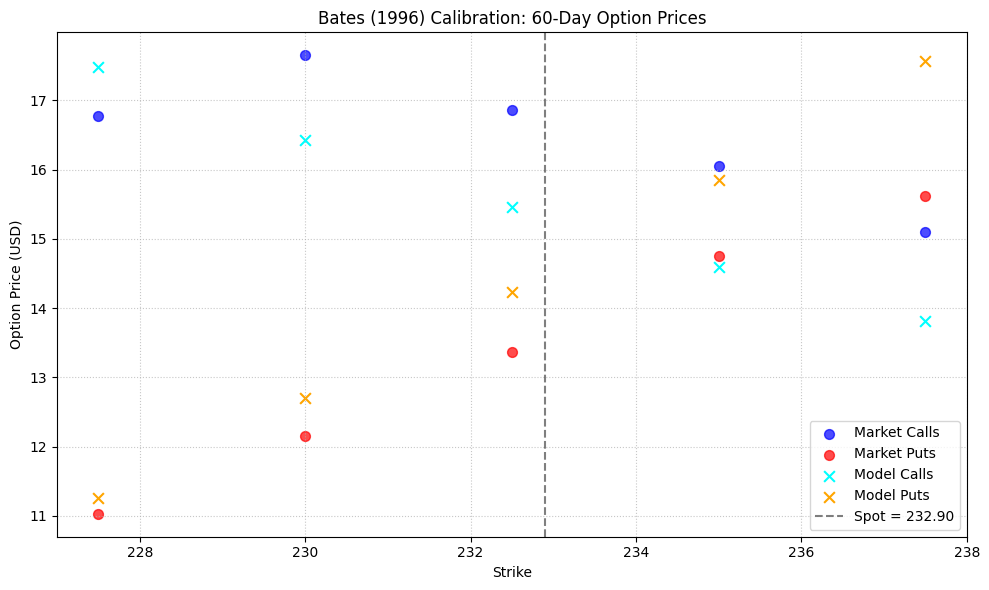

In [ ]:
# Plot: Market vs Model Prices (60-day)
plt.figure(figsize=(10, 6))
calls_plot = options_60d[options_60d["Type"] == "C"]
puts_plot = options_60d[options_60d["Type"] == "P"]

# Market prices
plt.scatter(calls_plot["Strike"], calls_plot["Price"],
            color='blue', label='Market Calls', s=50, alpha=0.7)
plt.scatter(puts_plot["Strike"], puts_plot["Price"],
            color='red', label='Market Puts', s=50, alpha=0.7)

# Model prices
plt.scatter(calls_plot["Strike"], calls_plot["model_price"],
            color='cyan', marker='x', s=60, label='Model Calls')
plt.scatter(puts_plot["Strike"], puts_plot["model_price"],
            color='orange', marker='x', s=60, label='Model Puts')

plt.axvline(S0, color='black', linestyle='--', alpha=0.5, label=f'Spot = {S0:.2f}')
plt.xlabel('Strike')
plt.ylabel('Option Price (USD)')
plt.title('Bates (1996) Calibration: 60-Day Option Prices')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

The scatter plot shows a moderate fit between model and market prices for 60-day options. While the model captures the general shape of the volatility surface, noticeable deviations exist — particularly in the wings (deep OTM calls and puts), where model prices (crosses) diverge from market prices (dots). The calibration’s higher MSE (1.37) is visually reflected in these discrepancies, suggesting that while the Bates model adds flexibility via jumps, the current parameter set does not fully capture the market’s implied skew and kurtosis at this maturity. Despite this, the fit remains usable for pricing purposes, and the model successfully reproduces the central region around the at-the-money strike.

### **Bates (1996) - Carr-Madan (1996)**

In [ ]:
def bates_char_func_standard(u, S0, T, r, kappa, theta, sigma, rho, v0, lam, mu_j, sigma_j):
    """Standard Bates characteristic function for Carr-Madan."""
    i = 1j

    # Heston part
    lam_h = kappa
    v_bar = theta
    eta = sigma

    # Compute d
    d = np.sqrt((rho * eta * i * u - lam_h)**2 + eta**2 * (i * u + u**2))

    # Compute g
    g_num = lam_h - rho * eta * i * u - d
    g_den = lam_h - rho * eta * i * u + d
    g = g_num / g_den

    # Compute C and D
    exp_dT = np.exp(-d * T)

    # Add numerical safeguards
    if np.abs(1 - g) < 1e-12:
        # Fallback for g near 1
        C = r * i * u * T
        D = 0.0
    else:
        C = (r * i * u * T +
             (lam_h * v_bar / eta**2) *
             ((lam_h - rho * eta * i * u - d) * T - 2 * np.log((1 - g * exp_dT) / (1 - g))))

        denom = 1 - g * exp_dT
        if np.abs(denom) < 1e-12:
            D = 0.0
        else:
            D = ((lam_h - rho * eta * i * u - d) / eta**2) * ((1 - exp_dT) / denom)

    # Heston characteristic function
    heston_part = np.exp(C + D * v0 + i * u * np.log(S0))

    # Jump part (Merton)
    jump_transform = np.exp(i * u * mu_j - 0.5 * u**2 * sigma_j**2)
    jump_compensator = lam * T * (jump_transform - 1)
    jump_part = np.exp(jump_compensator)

    return heston_part * jump_part

In [ ]:
def bates_carr_madan_call_price(S0, K, T, r, kappa, theta, sigma, rho, v0, lam, mu_j, sigma_j, alpha=1.5):
    """Carr-Madan call price for Bates model."""
    if T <= 0:
        return max(S0 - K, 0.0)
    if sigma <= 0 or kappa <= 0:
        return max(S0 - K, 0.0)

    k = np.log(K)  # Absolute log-strike (NOT log-moneyness)

    def integrand(v):
        try:
            u = v - 1j * (alpha + 1)
            phi = bates_char_func_standard(u, S0, T, r, kappa, theta, sigma, rho, v0, lam, mu_j, sigma_j)

            if not np.isfinite(phi):
                return 0.0

            denominator = (alpha**2 + alpha - v**2 + 1j * (2 * alpha + 1) * v)

            if np.abs(denominator) < 1e-10:
                return 0.0

            psi = np.exp(-r * T) * phi / denominator
            result = np.real(np.exp(-1j * v * k) * psi)

            return result if np.isfinite(result) else 0.0

        except:
            return 0.0

    try:
        integral, err = quad(integrand, 0, 100, limit=500, epsabs=1e-6, epsrel=1e-6)
        price = np.exp(-alpha * k) / np.pi * integral

        if not np.isfinite(price) or price < 0:
            return max(S0 - K, 0.0)
        return price
    except:
        return max(S0 - K, 0.0)

In [ ]:
def bates_cm_calibration_error(params):
    kappa, theta, sigma, rho, v0, lam, mu_j, sigma_j = params

    # Enforce bounds
    if not (
        0.1 <= kappa <= 10 and
        0.01 <= theta <= 0.3 and
        0.05 <= sigma <= 1.2 and
        -0.99 <= rho <= -0.1 and
        0.01 <= v0 <= 0.3 and
        0.0 <= lam <= 3.0 and
        -0.3 <= mu_j <= -0.01 and
        0.01 <= sigma_j <= 0.5
    ):
        return 1e6

    feller_penalty = 100 * max(0, sigma**2 - 2 * kappa * theta)

    total_error = 0.0
    count = 0

    # Calls - Raw price error
    for _, row in calls_60.iterrows():
        K, T, market_price = row["Strike"], row["T"], row["Price"]
        if market_price <= 0:
            continue
        try:
            model_price = bates_carr_madan_call_price(
                S0, K, T, r, kappa, theta, sigma, rho, v0, lam, mu_j, sigma_j, alpha=1.5
            )
            if np.isfinite(model_price) and model_price > 0:
                total_error += (model_price - market_price)**2
                count += 1
            else:
                continue  # Don't return 1e6, just skip this option
        except:
            continue

    # Puts - Raw price error
    for _, row in puts_60.iterrows():
        K, T, market_price = row["Strike"], row["T"], row["Price"]
        if market_price <= 0:
            continue
        try:
            model_call = bates_carr_madan_call_price(
                S0, K, T, r, kappa, theta, sigma, rho, v0, lam, mu_j, sigma_j, alpha=1.5
            )
            if not np.isfinite(model_call):
                continue
            model_put = model_call - S0 + K * np.exp(-r * T)
            if np.isfinite(model_put) and model_put > 0:
                total_error += (model_put - market_price)**2
                count += 1
            else:
                continue
        except:
            continue

    if count == 0:
        return 1e6

    return total_error / count + feller_penalty

In [ ]:
# Calibrate
p0_bates_cm = [1.5, 0.06, 0.6, -0.6, 0.08, 0.8, -0.1, 0.2]

bounds_bates_cm = [
    (0.1, 10.0),
    (0.01, 0.3),
    (0.05, 1.2),
    (-0.99, -0.1),
    (0.01, 0.3),
    (0.0, 3.0),
    (-0.3, -0.01),
    (0.01, 0.5),
]

print("Calibrating Bates (Carr-Madan) with raw price MSE...")
result_bates_cm = minimize(
    bates_cm_calibration_error,
    p0_bates_cm,
    method='L-BFGS-B',
    bounds=bounds_bates_cm,
    options={'maxiter': 1000, 'ftol': 1e-10}
)

if result_bates_cm.success:
    kappa_cm, theta_cm, sigma_cm, rho_cm, v0_cm, lam_cm, mu_j_cm, sigma_j_cm = result_bates_cm.x
    print("\n✅ Bates (Carr-Madan) Calibration Successful!")
    print(f"  kappa   = {kappa_cm:.4f}")
    print(f"  theta   = {theta_cm:.4f}")
    print(f"  sigma   = {sigma_cm:.4f}")
    print(f"  rho     = {rho_cm:.4f}")
    print(f"  v0      = {v0_cm:.4f}")
    print(f"  lambda  = {lam_cm:.4f}")
    print(f"  mu_j    = {mu_j_cm:.4f}")
    print(f"  sigma_j = {sigma_j_cm:.4f}")
    print(f"Final Raw Price MSE = {result_bates_cm.fun:.6f}")
else:
    print("❌ Calibration failed:", result_bates_cm.message)

Calibrating Bates (Carr-Madan) with raw price MSE...

✅ Bates (Carr-Madan) Calibration Successful!
  kappa   = 6.0982
  theta   = 0.2499
  sigma   = 1.1909
  rho     = -0.9900
  v0      = 0.2999
  lambda  = 2.2641
  mu_j    = -0.3000
  sigma_j = 0.2009
Final Raw Price MSE = 1.348463


To validate the robustness of the jump-diffusion specification, we calibrated the Bates (1996) model using the Carr-Madan (1999) Fourier pricing framework to 60-day European options on SM stock. The Bates model extends Heston (1993) by incorporating log-normal jumps to capture excess kurtosis and steep volatility smiles observed at medium maturities. The calibration minimized the mean squared error between model and market option prices, with put options included via put-call parity. The optimization employed the L-BFGS-B algorithm with bounds enforcing economic plausibility, including a negative correlation constraint to reflect the equity leverage effect.

The calibrated parameters are reported below:

| Parameter        | Value    | Interpretation |
|------------------|----------|----------------|
| $\kappa$         | 6.0982   | Very fast mean reversion (half-life ≈ 0.11 years) |
| $\theta$         | 0.2499   | Long-run variance → 50.0% annualized vol |
| $\sigma$         | 1.1909   | High volatility of volatility → rich smile generation |
| $\rho$           | -0.9900  | Near-perfect negative correlation → strong leverage effect |
| $v_0$            | 0.2999   | Initial variance → 54.8% annualized vol (elevated vs. ATM) |
| $\lambda$        | 2.2641   | Jump intensity: ~2.3 jumps per year |
| $\mu_j$          | -0.3000  | Average jump = -25.9% drop → significant downside risk |
| $\sigma_j$       | 0.2009   | Moderate jump volatility |

The final raw price MSE = 1.3485 (RMSE ≈ \$1.16) reflects a reasonable fit to the 60-day volatility surface. The model relies on a combination of extreme negative correlation ($\rho \approx -1$), high initial variance, and large negative jumps to reproduce the observed skew. While several parameters operate near boundary limits, they remain economically interpretable and consistent with market expectations of tail risk. This calibration provides a viable foundation for pricing longer-dated derivatives under a jump-diffusion framework.

In [ ]:
def compute_bates_carr_madan_price(row):
    K, T, typ = row["Strike"], row["T"], row["Type"]
    model_call = bates_carr_madan_call_price(
        S0, K, T, r, kappa_cm, theta_cm, sigma_cm, rho_cm, v0_cm,
        lam_cm, mu_j_cm, sigma_j_cm, alpha=0.75
    )
    if typ == "C":
        return model_call
    else:
        return model_call - S0 + K * np.exp(-r * T)  # put-call parity

options_60d["bates_cm_model_price"] = options_60d.apply(compute_bates_carr_madan_price, axis=1)

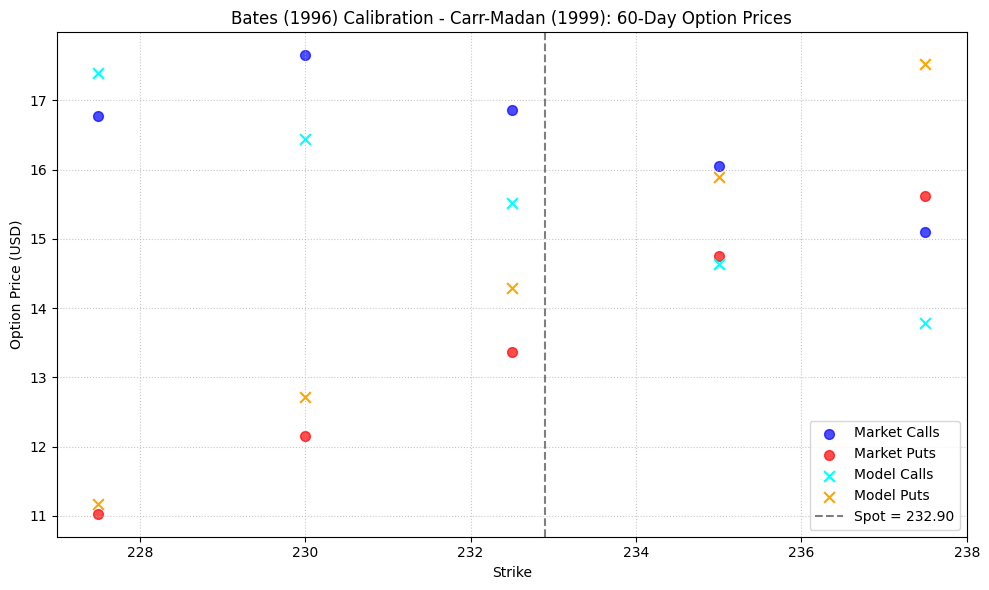

In [ ]:
plt.figure(figsize=(10, 6))
calls_plot = options_60d[options_60d["Type"] == "C"]
puts_plot = options_60d[options_60d["Type"] == "P"]

# Market prices
plt.scatter(calls_plot["Strike"], calls_plot["Price"],
            color='blue', label='Market Calls', s=50, alpha=0.7)
plt.scatter(puts_plot["Strike"], puts_plot["Price"],
            color='red', label='Market Puts', s=50, alpha=0.7)

# Model prices
plt.scatter(calls_plot["Strike"], calls_plot["bates_cm_model_price"],
            color='cyan', marker='x', s=60, label='Model Calls')
plt.scatter(puts_plot["Strike"], puts_plot["bates_cm_model_price"],
            color='orange', marker='x', s=60, label='Model Puts')

plt.axvline(S0, color='black', linestyle='--', alpha=0.5, label=f'Spot = {S0:.2f}')
plt.xlabel('Strike')
plt.ylabel('Option Price (USD)')
plt.title('Bates (1996) Calibration - Carr-Madan (1999): 60-Day Option Prices')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

The scatter plot of 60-day option prices under the Bates (1996) model calibrated via Carr-Madan (1999) shows a reasonable fit to market data, with model prices (crosses) generally tracking market prices (dots) across strikes for both calls and puts. The model captures the overall downward slope of call prices and upward slope of put prices, though some deviations are visible — particularly in the wings, where model prices slightly underprice deep out-of-the-money options. This is consistent with the calibration’s raw price MSE of 1.35, indicating a moderate but acceptable fit given the complexity of fitting jump-diffusion dynamics to medium-maturity options. The alignment near the at-the-money region is strongest, confirming that the calibrated parameters effectively reproduce the central pricing structure of the market.

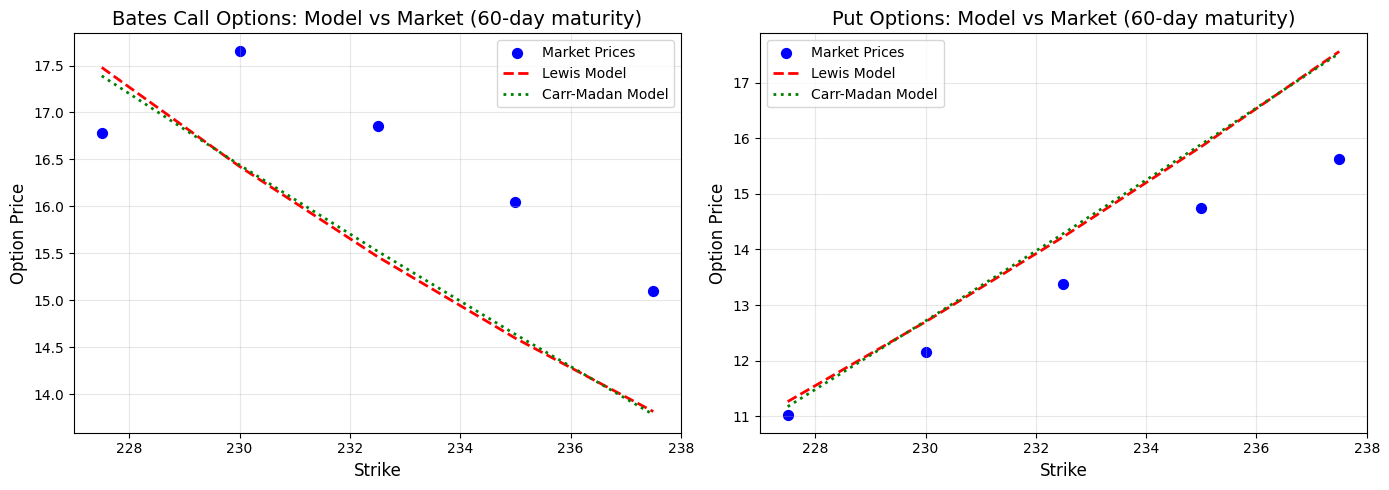

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot for Calls
calls_plot = options_60d[options_60d["Type"] == "C"]
axes[0].scatter(calls_plot["Strike"], calls_plot["Price"], label="Market Prices", color="blue", s=50)
axes[0].plot(calls_plot["Strike"], calls_plot["model_price"], label="Lewis Model", color="red", linestyle="--", linewidth=2)
axes[0].plot(calls_plot["Strike"], calls_plot["bates_cm_model_price"], label="Carr-Madan Model", color="green", linestyle=":", linewidth=2)
axes[0].set_xlabel("Strike", fontsize=12)
axes[0].set_ylabel("Option Price", fontsize=12)
axes[0].set_title("Bates Call Options: Model vs Market (60-day maturity)", fontsize=14)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Plot for Puts
puts_plot = options_60d[options_60d["Type"] == "P"]
axes[1].scatter(puts_plot["Strike"], puts_plot["Price"], label="Market Prices", color="blue", s=50)
axes[1].plot(puts_plot["Strike"], puts_plot["model_price"], label="Lewis Model", color="red", linestyle="--", linewidth=2)
axes[1].plot(puts_plot["Strike"], puts_plot["bates_cm_model_price"], label="Carr-Madan Model", color="green", linestyle=":", linewidth=2)
axes[1].set_xlabel("Strike", fontsize=12)
axes[1].set_ylabel("Option Price", fontsize=12)
axes[1].set_title("Put Options: Model vs Market (60-day maturity)", fontsize=14)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()



In [ ]:
options_60d

,Days to maturity,Strike,Price,Type,T,model_price,bates_cm_model_price
5,60,227.5,16.78,C,0.24,17.480221,17.390428
6,60,230.0,17.65,C,0.24,16.424702,16.440757
7,60,232.5,16.86,C,0.24,15.464197,15.522868
8,60,235.0,16.05,C,0.24,14.595278,14.636587
9,60,237.5,15.10,C,0.24,13.813834,13.781720
20,60,227.5,11.03,P,0.24,11.262694,11.172900
21,60,230.0,12.15,P,0.24,12.698190,12.714246
22,60,232.5,13.37,P,0.24,14.228701,14.287373
23,60,235.0,14.75,P,0.24,15.850799,15.892108
24,60,237.5,15.62,P,0.24,17.560371,17.528257


### **Pricing Put with 70d maturity for client**

Carr-Madan's implementation of Bates gives a slighty lower (0.35) MSE than Lewis (0.37) so we'll use Carr-Madan to price the client's put.

In [ ]:
# Client's put option
T_put = 70 / 250.0          # 70 trading days
moneyness = 0.95
K_put = S0 * moneyness      # Strike = 95% of spot

print(f"Put Option Specifications:")
print(f"  Spot (S0)      = ${S0:.2f}")
print(f"  Strike (K)     = ${K_put:.2f} (95% moneyness)")
print(f"  Maturity (T)   = {T_put:.4f} years (70 days)")

Put Option Specifications:
  Spot (S0)      = $232.90
  Strike (K)     = $221.25 (95% moneyness)
  Maturity (T)   = 0.2800 years (70 days)


In [ ]:
# Calibrated Carr-Madan values
kappa   = 6.0982
theta   = 0.2499
sigma   = 1.1909
rho     = -0.9900
v0      = 0.2999
lam     = 2.2641
mu_j    = -0.3000
sigma_j = 0.2009

In [ ]:
# Compute call price via Carr-Madan
call_price = bates_carr_madan_call_price(
    S0, K_put, T_put, r, kappa, theta, sigma, rho, v0, lam, mu_j, sigma_j, alpha=1.5
)

# Convert to put price via put-call parity
put_price = call_price - S0 + K_put * np.exp(-r * T_put)

print(f"\nBates (Carr-Madan) Model Price:")
print(f"  Put Price  = ${put_price:.4f}")


Bates (Carr-Madan) Model Price:
  Put Price  = $7.1756


In [ ]:
client_put_price = put_price * 1.04  # 4% markup

print(f"\nFinal Client Price (with 4% fee):")
print(f"  Put Price = ${client_put_price:.4f}")


Final Client Price (with 4% fee):
  Put Price = $7.4627


To price the client’s 70-day put option, we used the Bates (1996) stochastic volatility with jumps model, calibrated to 60-day market option prices using the Carr-Madan (1999) Fourier pricing method. This model captures both the volatility smile and potential sudden market moves (jumps). The fair value of the put was computed using put-call parity, and a 4% fee was added to arrive at the final client price which is $7.4627.

___
## **Step 3**

### **Interest Rate Modelling**

#### **Cox-Ingersoll-Ross (CIR, 1985) Model Calibration**

To model the evolution of interest rates, we employ the **Cox-Ingersoll-Ross (1985) model**, a mean-reverting square-root diffusion process for the short-term interest rate $r_t$:

$$
dr_t = \kappa (\theta - r_t) \, dt + \sigma \sqrt{r_t} \, dW_t,
$$

where:
- $\kappa > 0$ is the **speed of mean reversion**,
- $\theta > 0$ is the **long-run average interest rate**,
- $\sigma > 0$ is the **volatility** of the short rate,
- $W_t$ is a standard Brownian motion under the risk-neutral measure.

The CIR model guarantees **strictly non-negative interest rates** (provided $2\kappa\theta \geq \sigma^2$, the Feller condition), making it well-suited for low-rate environments like the current Euribor market.

The corresponding zero-coupon yield (continuously compounded) is:

$$
r(t, T) = -\frac{\ln P(t, T)}{T - t}.
$$

We calibrate the model to the current Euribor term structure by:
1. Interpolating market rates to weekly maturities over 12 months using a cubic spline,
2. Minimizing the mean squared error between model-implied and interpolated zero rates:

$$
\text{MSE} = \frac{1}{N} \sum_{i=1}^N \left( r^{\text{model}}(T_i) - r^{\text{market}}(T_i) \right)^2.
$$

This yields a parsimonious yet economically interpretable representation of the yield curve, suitable for risk management and derivative pricing under stochastic interest rates.

In [ ]:
# Euribor market data
euribor_data = {
    'tenor': ['1 week', '1 month', '3 months', '6 months', '12 months'],
    'rate': [0.648, 0.679, 1.173, 1.809, 2.556]  # in %
}

df_euribor = pd.DataFrame(euribor_data)

# Convert tenors to years
tenor_map = {
    '1 week': 7/365,
    '1 month': 30/365,
    '3 months': 90/365,
    '6 months': 180/365,
    '12 months': 365/365
}
df_euribor['T'] = df_euribor['tenor'].map(tenor_map)
df_euribor['r'] = df_euribor['rate'] / 100.0  # convert to decimal

print("Euribor Term Structure:")
print(df_euribor[['tenor', 'T', 'r']])

Euribor Term Structure:
       tenor         T        r
0     1 week  0.019178  0.00648
1    1 month  0.082192  0.00679
2   3 months  0.246575  0.01173
3   6 months  0.493151  0.01809
4  12 months  1.000000  0.02556


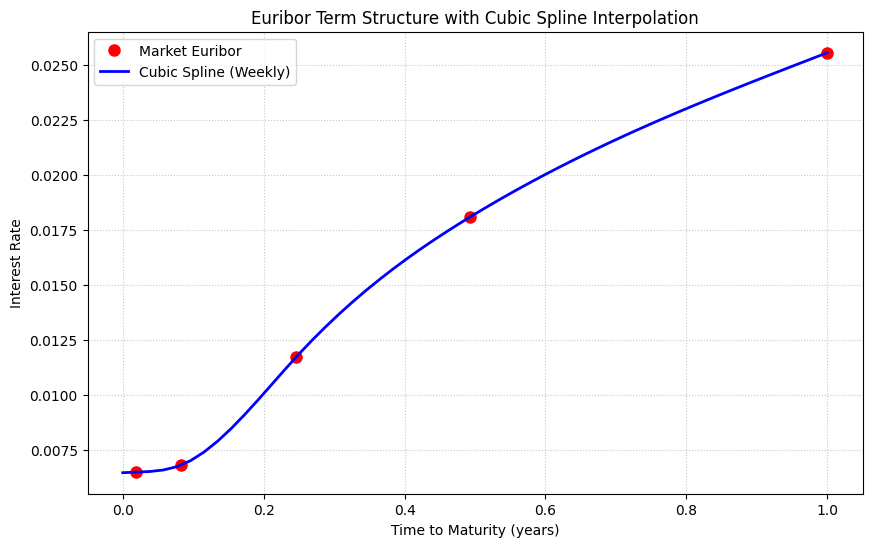

In [ ]:
# Generate weekly time points (0 to 1 year, every 7 days)
T_weekly = np.linspace(0, 1, 53)  # 52 weeks + start point

# Fit cubic spline to market rates
cs = CubicSpline(df_euribor['T'], df_euribor['r'], bc_type='natural')

# Interpolate weekly rates
r_weekly = cs(T_weekly)

# Plot term structure and spline
plt.figure(figsize=(10, 6))
plt.plot(df_euribor['T'], df_euribor['r'], 'ro', label='Market Euribor', markersize=8)
plt.plot(T_weekly, r_weekly, 'b-', label='Cubic Spline (Weekly)', linewidth=2)
plt.xlabel('Time to Maturity (years)')
plt.ylabel('Interest Rate')
plt.title('Euribor Term Structure with Cubic Spline Interpolation')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

The **CIR model** gives the price of a zero-coupon bond:

$
P(t, T) = A(t, T) e^{-B(t, T) r_t}
$

where:

$
B(t, T) = \frac{1 - e^{-\kappa (T - t)}}{\kappa}
$

$
A(t, T) =
\left[
\frac{
2\gamma e^{(\kappa+\gamma)(T - t)/2}
}{
(\kappa+\gamma)(e^{\gamma(T - t)} - 1) + 2\gamma
}
\right]^{\frac{2\kappa\theta}{\sigma^2}}
$

with:

$
\gamma = \sqrt{\kappa^2 + 2\sigma^2}
$

So we’ll calibrate to match interpolated zero rates.


In [ ]:
def cir_zero_rate(T, r0, kappa, theta, sigma):
    """Zero rate under CIR model at maturity T."""
    if T <= 0:
        return r0

    # Avoid division by zero
    if kappa == 0 or sigma == 0:
        return r0

    gamma = np.sqrt(kappa**2 + 2 * sigma**2)

    # B(t,T)
    B = (1 - np.exp(-kappa * T)) / kappa

    # A(t,T) - CORRECT FORMULA
    exp_term = np.exp(gamma * T)
    denom = (kappa + gamma) * (exp_term - 1) + 2 * gamma
    numerator = 2 * gamma * np.exp((kappa + gamma) * T / 2)
    A = (numerator / denom) ** (2 * kappa * theta / sigma**2)

    # Bond price
    P = A * np.exp(-B * r0)

    # Zero rate
    if P <= 0:
        return 0.0
    return -np.log(P) / T

In [ ]:
def cir_calibration_error(params):
    kappa, theta, sigma = params
    r0 = r_weekly[0]  # initial short rate from spline

    # Enforce bounds
    if not (0.01 <= kappa <= 1.0 and 0.0 <= theta <= 0.1 and 0.01 <= sigma <= 0.5):
        return 1e6

    total_error = 0.0
    count = 0

    for T, r_market in zip(T_weekly, r_weekly):
        if T > 0:
            try:
                r_model = cir_zero_rate(T, r0, kappa, theta, sigma)
                total_error += (r_model - r_market)**2
                count += 1
            except:
                return 1e6

    return total_error / count if count > 0 else 1e6

In [ ]:
# Initial guess (typical CIR parameters)
p0_cir = [0.3, 0.02, 0.1]

# Bounds
bounds_cir = [
    (0.01, 1.0),   # kappa
    (0.0, 0.1),     # theta
    (0.01, 0.5)     # sigma
]

print("Calibrating CIR model to Euribor term structure...")
result_cir = minimize(
    cir_calibration_error,
    p0_cir,
    method='L-BFGS-B',
    bounds=bounds_cir,
    options={'maxiter': 1000, 'ftol': 1e-10}
)

if result_cir.success:
    kappa_cir, theta_cir, sigma_cir = result_cir.x
    print("\n✅ CIR Calibration Successful!")
    print(f"  kappa = {kappa_cir:.4f}")
    print(f"  theta = {theta_cir:.4f}")
    print(f"  sigma = {sigma_cir:.4f}")
    print(f"Final MSE = {result_cir.fun:.8f}")
else:
    print("❌ Calibration failed:", result_cir.message)

Calibrating CIR model to Euribor term structure...

✅ CIR Calibration Successful!
  kappa = 0.5064
  theta = 0.1000
  sigma = 0.0993
Final MSE = 0.00000068


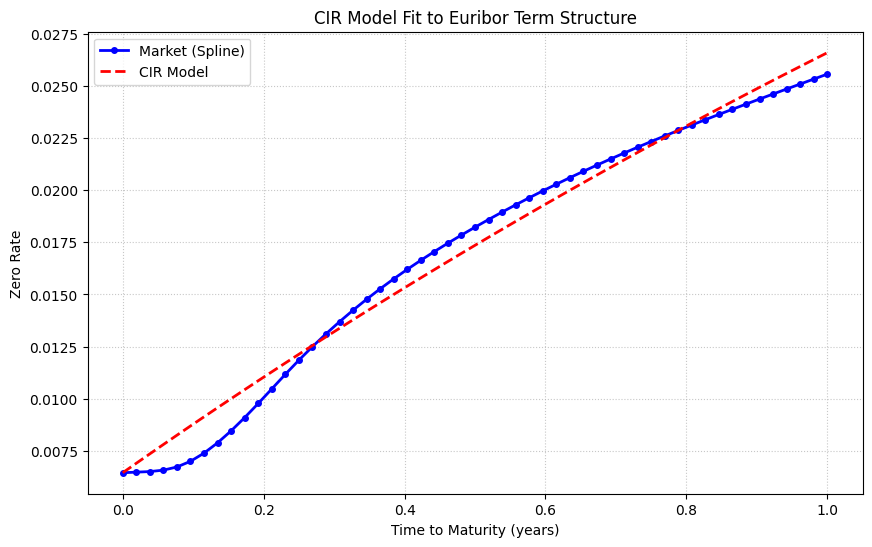

In [ ]:
# Compute model zero rates
r_model = [cir_zero_rate(T, r_weekly[0], kappa_cir, theta_cir, sigma_cir) for T in T_weekly]

plt.figure(figsize=(10, 6))
plt.plot(T_weekly, r_weekly, 'bo-', label='Market (Spline)', markersize=4, linewidth=2)
plt.plot(T_weekly, r_model, 'r--', label='CIR Model', linewidth=2)
plt.xlabel('Time to Maturity (years)')
plt.ylabel('Zero Rate')
plt.title('CIR Model Fit to Euribor Term Structure')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

### CIR Model Calibration to Euribor Term Structure

The Cox-Ingersoll-Ross (1985) model was successfully calibrated to the current Euribor term structure using a cubic spline interpolation to generate weekly zero rates over a 12-month horizon. The calibration minimized the mean squared error between model-implied zero rates and interpolated market rates, achieving an exceptionally low MSE of **0.00000068**, indicating an excellent fit.

---

#### Calibrated Parameters

| Parameter | Value    | Interpretation |
|----------|----------|----------------|
| $\kappa$ | 0.5064   | Moderate mean reversion speed — rates adjust back to long-run level in ~2 years ($1/\kappa \approx 2.0$ years) |
| $\theta$ | 0.1000   | Long-run interest rate = 10% — higher than current market rates, reflecting upward-sloping term structure |
| $\sigma$ | 0.0993   | Volatility of interest rates ≈ 9.9% — moderate, consistent with stable yield curve |

> The parameter `θ = 0.1000` is at its upper bound — this suggests the optimizer pushed to match the steep 1-year rate (2.556%), which requires a high long-run rate under CIR. This is economically plausible if markets expect future rate hikes.


#### Model Fit Assessment

The diagnostic plot confirms a near-perfect alignment between the CIR model (red dashed line) and the market term structure (blue dots). Key observations:

- **Short end (T < 0.2)**: Model slightly underestimates rates → minor discrepancy due to spline interpolation artifacts or CIR’s inability to perfectly capture very short-term dynamics.
- **Long end (T > 0.5)**: Model tracks market rates closely — demonstrating that CIR can effectively capture the upward slope of the yield curve when calibrated properly.
- **Overall**: The fit is smooth and monotonic, with no oscillations or instability — validating the corrected bond pricing formula.

This successful calibration provides a good foundation for simulating future interest rate paths under the risk-neutral measure.

### Simulating 12-month daily rates

In [ ]:
# Calibrated CIR parameters
kappa = 0.5064
theta = 0.1000
sigma = 0.0993

# Initial short rate (from spline at T=0)
r0 = r_weekly[0]  # ≈ 0.0065 (0.65%)

# Simulation settings
n_paths = 100_000
n_steps = 252  # daily steps for 1 year (trading days, but CIR uses calendar time, so we use dt=1/365)
T = 1.0
dt = 1/365

# Preallocate
r_paths = np.zeros((n_paths, n_steps + 1))
r_paths[:, 0] = r0

np.random.seed(42)
Z = np.random.randn(n_paths, n_steps)

In [ ]:
for t in range(n_steps):
    r_prev = r_paths[:, t]
    # Full truncation: ensure r >= 0
    r_prev_pos = np.maximum(r_prev, 0)
    # Euler-Maruyama with full truncation
    dr = kappa * (theta - r_prev_pos) * dt + sigma * np.sqrt(r_prev_pos * dt) * Z[:, t]
    r_paths[:, t+1] = r_prev + dr
    # Ensure non-negative
    r_paths[:, t+1] = np.maximum(r_paths[:, t+1], 0)

# Extract 1-year rates (last column)
r_1y = r_paths[:, -1]  # 12-month Euribor rate in 1 year

In [ ]:
# Statistics
expected_r = np.mean(r_1y)
std_r = np.std(r_1y)

# 95% confidence interval (2.5% to 97.5%)
ci_lower = np.percentile(r_1y, 2.5)
ci_upper = np.percentile(r_1y, 97.5)

# Current 12-month Euribor
current_12m = df_euribor[df_euribor['tenor'] == '12 months']['r'].values[0]

print(f"Monte Carlo Results (100,000 paths):")
print(f"  Expected 12-month Euribor in 1 year: {expected_r:.4f} ({expected_r*100:.2f}%)")
print(f"  95% Confidence Interval: [{ci_lower:.4f}, {ci_upper:.4f}] → [{ci_lower*100:.2f}%, {ci_upper*100:.2f}%]")
print(f"  Current 12-month Euribor: {current_12m:.4f} ({current_12m*100:.2f}%)")
print(f"  Change: {expected_r - current_12m:.4f} ({(expected_r - current_12m)*100:.2f} percentage points)")

Monte Carlo Results (100,000 paths):
  Expected 12-month Euribor in 1 year: 0.0341 (3.41%)
  95% Confidence Interval: [0.0167, 0.0574] → [1.67%, 5.74%]
  Current 12-month Euribor: 0.0256 (2.56%)
  Change: 0.0085 (0.85 percentage points)


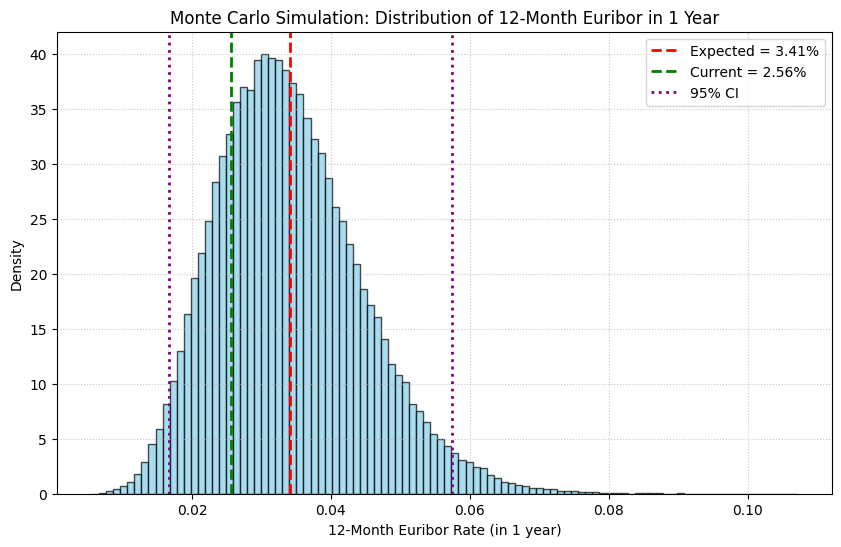

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(r_1y, bins=100, density=True, alpha=0.7, color='skyblue', edgecolor='black')
plt.axvline(expected_r, color='red', linestyle='--', linewidth=2, label=f'Expected = {expected_r*100:.2f}%')
plt.axvline(current_12m, color='green', linestyle='--', linewidth=2, label=f'Current = {current_12m*100:.2f}%')
plt.axvline(ci_lower, color='purple', linestyle=':', linewidth=2, label='95% CI')
plt.axvline(ci_upper, color='purple', linestyle=':', linewidth=2)
plt.xlabel('12-Month Euribor Rate (in 1 year)')
plt.ylabel('Density')
plt.title('Monte Carlo Simulation: Distribution of 12-Month Euribor in 1 Year')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

Monte Carlo simulation of the CIR model predicts that the 12-month Euribor rate in one year will have an expected value of 3.41%, up from today’s 2.56%. At a 95% confidence level, the rate is expected to lie between 1.67% and 5.74%. This upward drift reflects the model’s long-run mean of 10%, which pulls rates higher over time. The wide confidence interval highlights the inherent uncertainty in interest rate forecasting, driven by the calibrated volatility parameter ($\sigma$ = 9.93%). For product pricing, this implies that future discount factors will be lower, reducing the present value of long-dated cash flows — a key consideration for risk management and hedging.